# PCA Report for Arrests made in US

#### This data set contains statistics, in arrests per 100,000 residents, for assault, murder, and rape in each of the 50 US states in 1973. Also given is the percent of the population living in urban areas.

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler,MinMaxScaler, LabelEncoder, normalize
from sklearn.decomposition import PCA
from pca import pca


from sklearn.metrics import accuracy_score, silhouette_score

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage



df = pd.read_csv('USArrests.csv')
# Correct city column by renaming to state
df.rename(columns={"City": "State"}, inplace=True)
print(f'Shape = {df.shape}')
df.head()


Shape = (50, 5)


,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


There are 5 features within out dataframe. 

* There are 3 types of crimes (Murder, Assualt and Rape) and the numbers featured relate to the number of arrests made per 100,000 residents within each of the 50 states
* The Urban population for each state is also featured.

The aim of this report is to use PCA and hierarchical clustering to represent how each crime attributes itself to each state. We will impose segration on our data as state bring the response variable, while crime and population are our predictor values.


In [18]:
# Convert all numerical fearues to the same datatype
df['Assault'] = df['Assault'].astype('float64')
df['UrbanPop'] = df['UrbanPop'].astype('float64')
df.dtypes

State        object
Murder      float64
Assault     float64
UrbanPop    float64
Rape        float64
dtype: object

In [19]:
# check for any missing values
print(f'Checking for missing values:\n{df.isnull().sum()}')

Checking for missing values:
State       0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64


In [20]:
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


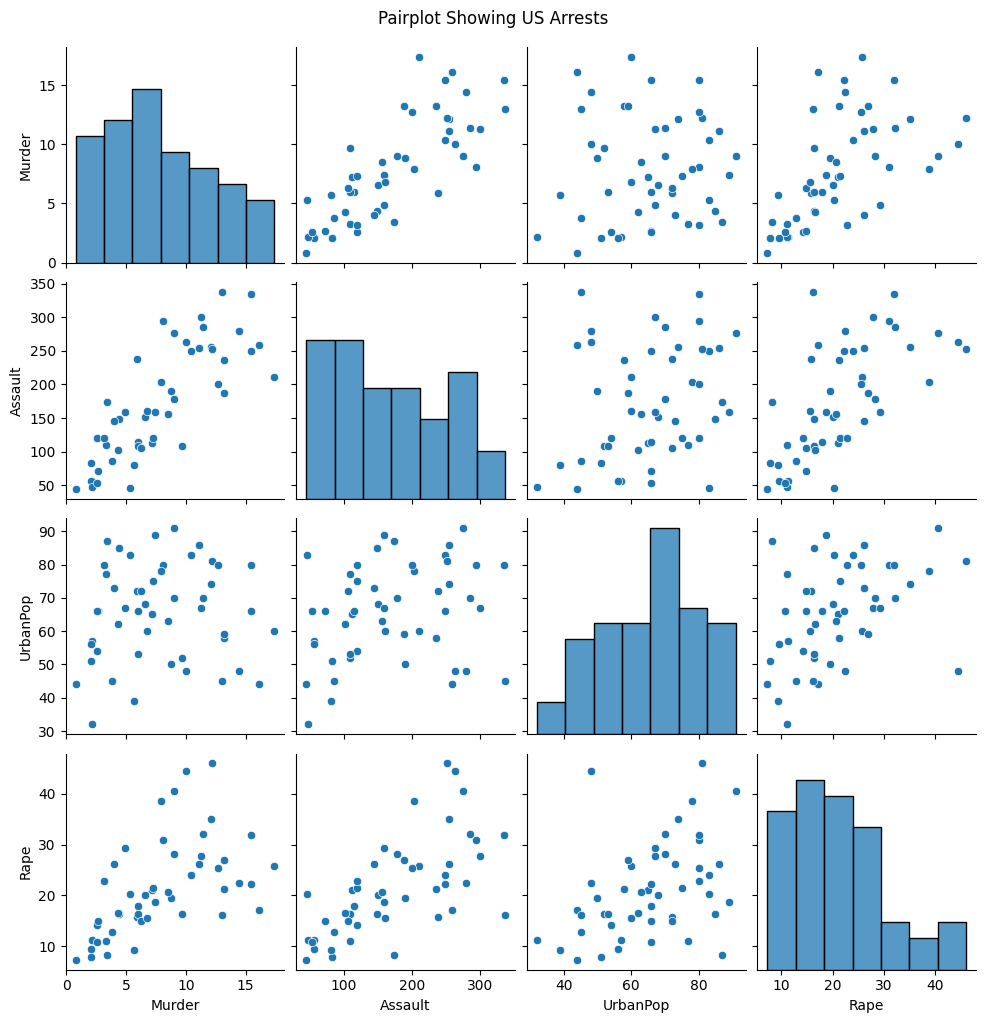

In [21]:
# use pairplots to see how the data is correlates
pp = sns.pairplot(df)
pp.fig.suptitle('Pairplot Showing US Arrests', y=1.02)
plt.show()

#### Observations

There are postive correlations between assault and rape,murder and rape, and between murder and assault.

There is aslo a postive correlation between UrbanPop and rape

This can be seen further using a heatmap

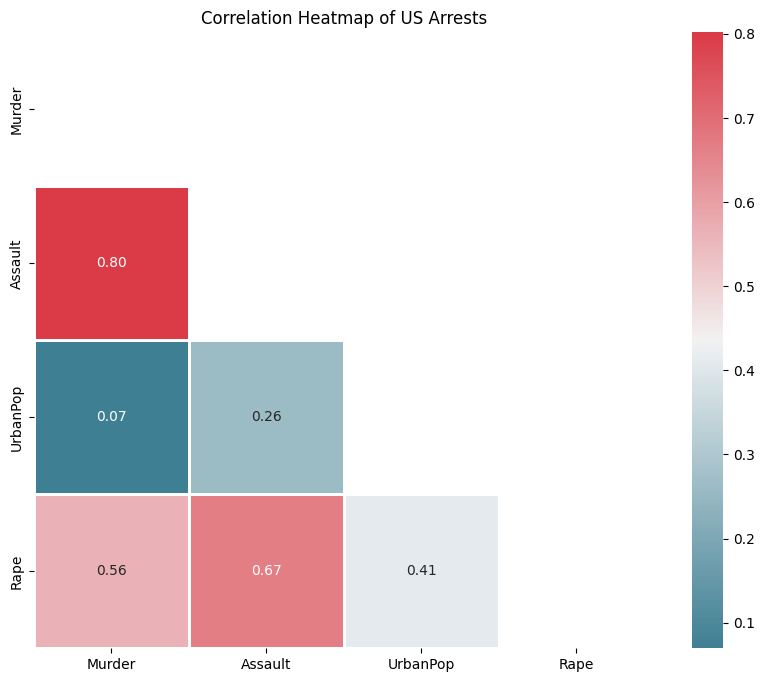

In [22]:
# look at how data features correlate with one another
colormap = sns.diverging_palette(220, 10, as_cmap=True)

def corr_heatmap(df_crimes):
  # get correlations
  Arrest_corrs = df_crimes.corr(numeric_only=True)
  # pick appropriate palette for heatmap
  # Plot figsize
  fig, ax = plt.subplots(figsize=(10, 8))
  # to mask mirrored side of heatmap
  dropSelf = np.zeros_like(Arrest_corrs)
  dropSelf[np.triu_indices_from(dropSelf)] = True
  # Generate Heat Map, with annotations of the correlation strength and 2-decimal floats
  ax = sns.heatmap(Arrest_corrs, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2)
  plt.title('Correlation Heatmap of US Arrests')
  plt.show()

corr_heatmap(df)

Understanding distribution of our data is a vital aspect of producing accurate reports.

It is difficult to make comparisons between Urbanpop which is show as a percentage and the number of murders/rapes/assualts which are distinct numerical values.

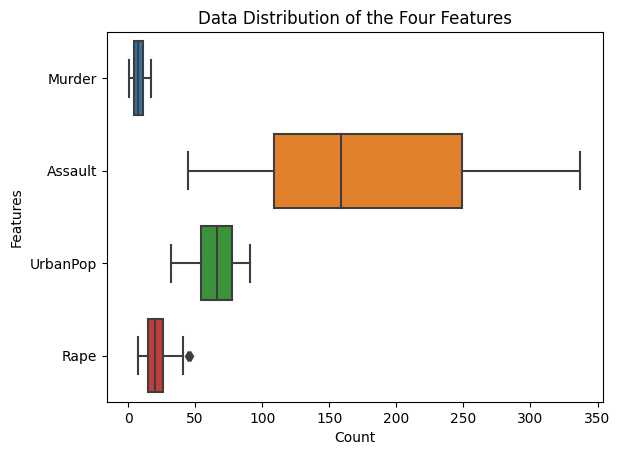

In [23]:
# Use boxplot to show distbution of each feature
sns.boxplot(data=df, orient='h')
plt.ylabel('Features')
plt.xlabel('Count')
plt.title('Data Distribution of the Four Features')
plt.show()

#### Observations

There are more Assualt arrests recorded in the dataset than any other crime.

Murder has the lowest number of arrests recorded in the dataset.

Note: UrbanPop is a percentage so will not go beyond 100

### Data Scaling

In [24]:
# select and standardize features
X_scaled = StandardScaler().fit_transform(df.iloc[:, 1:5])
print(X_scaled.shape)

df_scale = pd.DataFrame(X_scaled, columns=df.columns[1:5])
df_scale.head()

(50, 4)


,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


### PCA

We are looking for a variance factor between 80% to 90% for our components. The absolute minmum threshold for variance should not be below 60% as this would open up a bias for unreliable data.

In [25]:
# Show how each component attributes 
pc = PCA().fit(df_scale)

pc.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

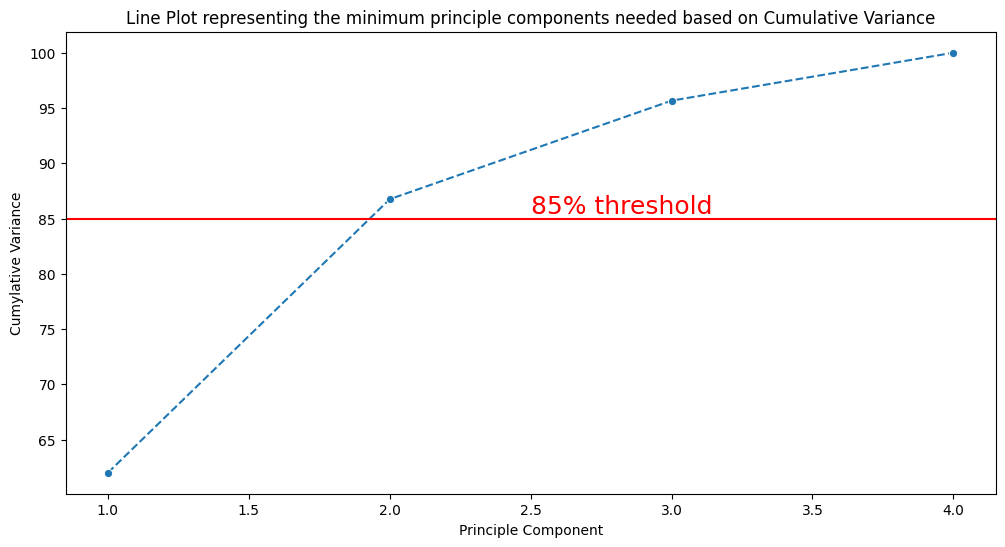

In [26]:
# create a graph to show the minumum number of components needed for analysis
X = np.arange(1, 5, step=1)
plt.figure(figsize=(12, 6))
sns.lineplot(x=X, y=np.cumsum(pc.explained_variance_ratio_)*100, linestyle='--', marker='o')
plt.title('Line Plot representing the minimum principle components needed based on Cumulative Variance')
plt.xlabel('Principle Component')
plt.ylabel('Cumylative Variance')
plt.axhline(y=85, color='r', linestyle='-')
plt.text(2.5, 85.5, '85% threshold', color='r', fontsize=18)
plt.show()

Based on the graph above we will proceed with working with 2 components

In [27]:
#proceed with 2 componetns
pc = PCA(n_components=2)

# obtain components
principal_components = pc.fit_transform(df_scale)
print(principal_components.shape)
# transform the components into a pandas data frame
pca_df = pd.DataFrame(principal_components, columns=['pc 1', 'pc 2'])
pca_df['State'] = df['State']
# This is to include the country code  as the rownames in the PC's
pca_df.head()

(50, 2)


,pc 1,pc 2,State
0,0.985566,1.133392,Alabama
1,1.950138,1.073213,Alaska
2,1.763164,-0.745957,Arizona
3,-0.141420,1.119797,Arkansas
4,2.523980,-1.542934,California


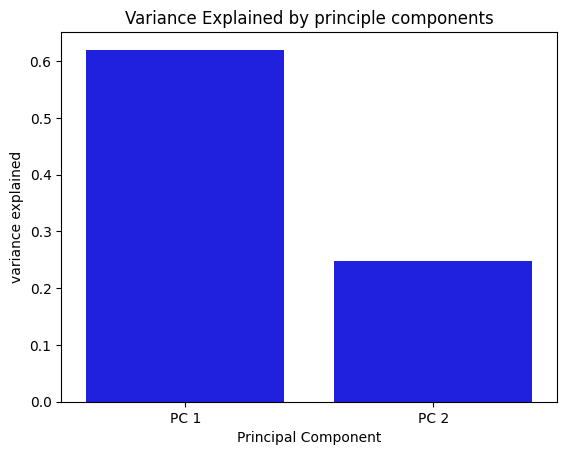

In [28]:
# create a barplot to visually represent how each Component affects the variance

variance_df = pd.DataFrame({'variance explained': pc.explained_variance_ratio_, 'Principal Component': ['PC 1', 'PC 2']})

plt.title('Variance Explained by principle components')
sns.barplot(x='Principal Component', y='variance explained', data=variance_df, color='b')
plt.show()

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 with loadings.


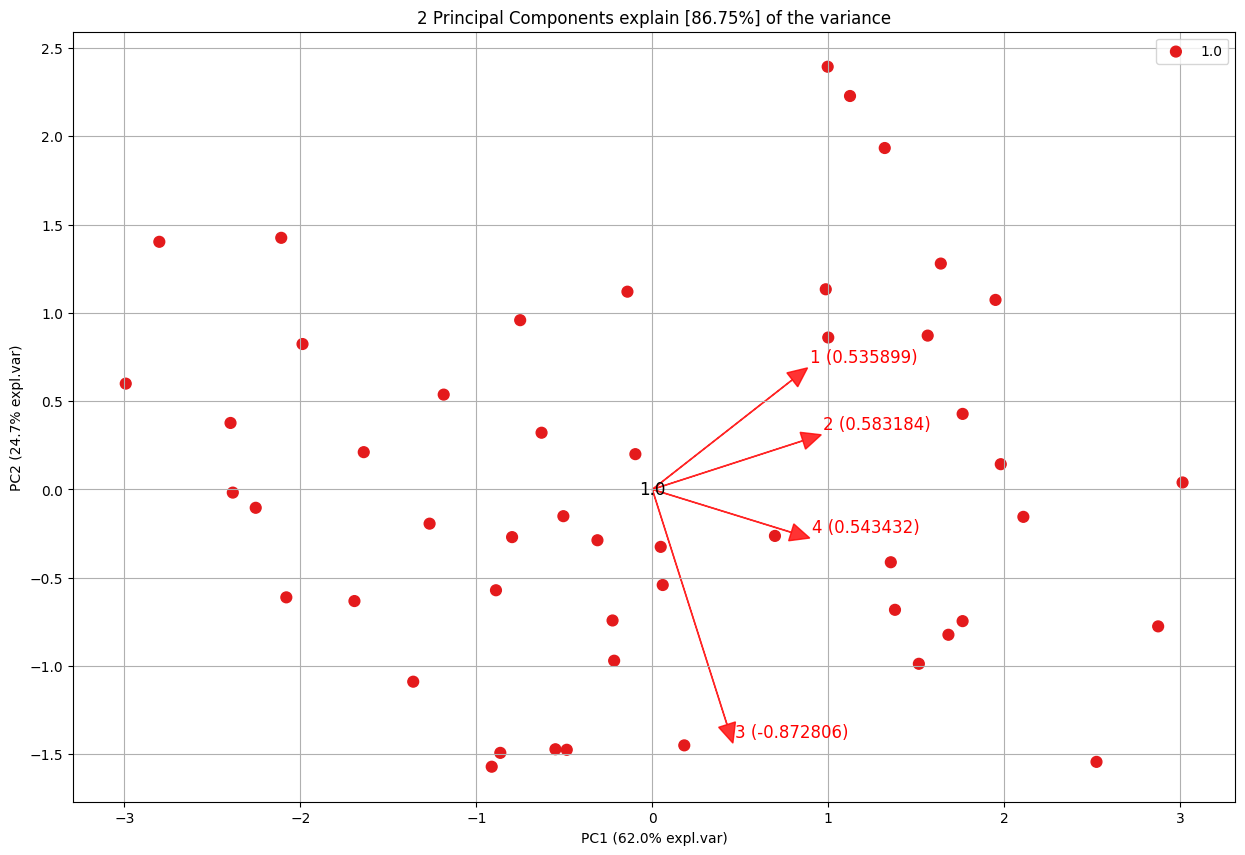

In [30]:
# create biplot to represent components 
model = pca(n_components=2)
results = model.fit_transform(X_scaled)

fig, ax = model.biplot(n_feat=4)

### Clustering Analysis

In [ ]:
# user Axes3D for 3D plot when clustering

 Use the dataset UsArrests.csv included in this folder to generate a similar in-depth PCA report of the data. Explore as much as you can, motivate the pre-processing steps you take, and interpret the outcomes of any analyses.


You are also required to do an application of two clustering techniques and an analysis of the clusters they generate. Try and see if you can find anything common within each cluster that has been found.


Push all the work that you have generated for this project to GitHub